In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += (other.data * out.grad)
            other.grad += (self.data * out.grad)
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**(-1)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        t = self.data
        x = (math.exp(2*t)-1)/(math.exp(2*t)+1)
        out = Value(x, (self,), "tanh")
        def _backward():
            self.grad += (1-x**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):  
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes: 
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

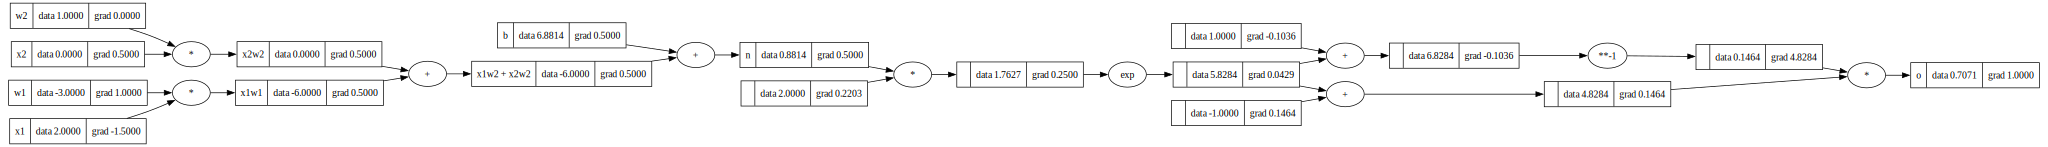

In [4]:
#neuron modeling test with two inputs

x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")  

#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias
b = Value(6.881373587019543, label = "b")
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"

#everything combined together
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w2 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = "o"

""" Manual Back Propagation
o.grad = 1.0
n.grad = (1-o.data**2)
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
"""

""" Manually Calling Back Propagation
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
"""
o.backward()
draw_dot(o)

In [5]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.881373587019543]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


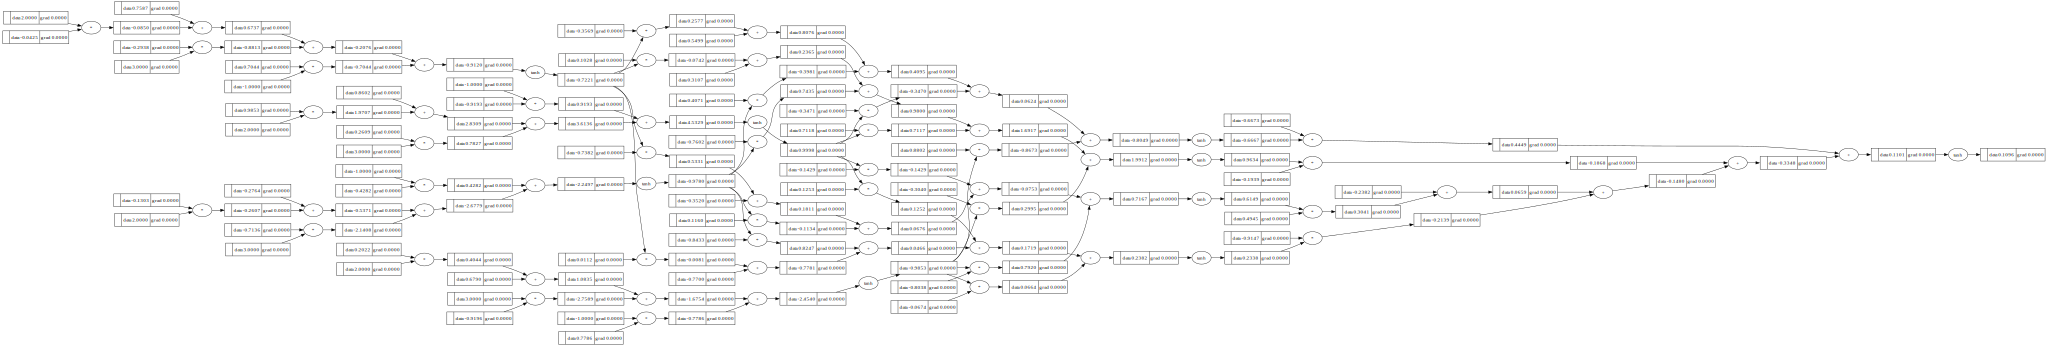

In [6]:
from typing import NoReturn


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
       act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
       out = act.tanh()
       return out
    def parameters (self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        """
        params = []
        for neurons in self.neurons:
            ps = neurons.parameters()
            params.extend(ps)
        return params
        """

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
    
draw_dot(n(x))

In [7]:
xs = [
[2.0, 3.0, -1.0],
[3.0, -1.0, 0.5],
[0.5, 1.0, 1.0],
[1.0, 1.0, -1.0],
] 

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=0.10964622323741842),
 Value(data=-0.6599141542800577),
 Value(data=-0.76782729085993),
 Value(data=0.08472670066094162)]

In [8]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip (ys, ypred)])
print(loss)
loss.backward()
print(n.layers[0].neurons[0].w[0].grad)

Value(data=1.8000176096068865)
0.5267125645492026


In [10]:
n.parameters()

[Value(data=-0.04249822793481095),
 Value(data=-0.29375039280265924),
 Value(data=0.704427295524652),
 Value(data=0.7586579781536162),
 Value(data=-0.13034232646360855),
 Value(data=-0.7135862690842307),
 Value(data=-0.42818764504682516),
 Value(data=-0.2764461934730327),
 Value(data=0.9853338927902893),
 Value(data=0.26089256358848023),
 Value(data=-0.9193327943163374),
 Value(data=0.8602276094596062),
 Value(data=0.20221904614826647),
 Value(data=-0.9196311546352491),
 Value(data=0.7785690956847422),
 Value(data=0.6790218079611243),
 Value(data=-0.7382028819706645),
 Value(data=0.11598917206814141),
 Value(data=-0.14292437973680294),
 Value(data=-0.8037622684710011),
 Value(data=-0.3519931237307312),
 Value(data=0.011192932303482062),
 Value(data=-0.8432523122373192),
 Value(data=0.12527025112490886),
 Value(data=-0.06737487699922351),
 Value(data=-0.770020099778641),
 Value(data=0.10275464461796391),
 Value(data=-0.7602400923560921),
 Value(data=0.7118473376625865),
 Value(data=-0.3

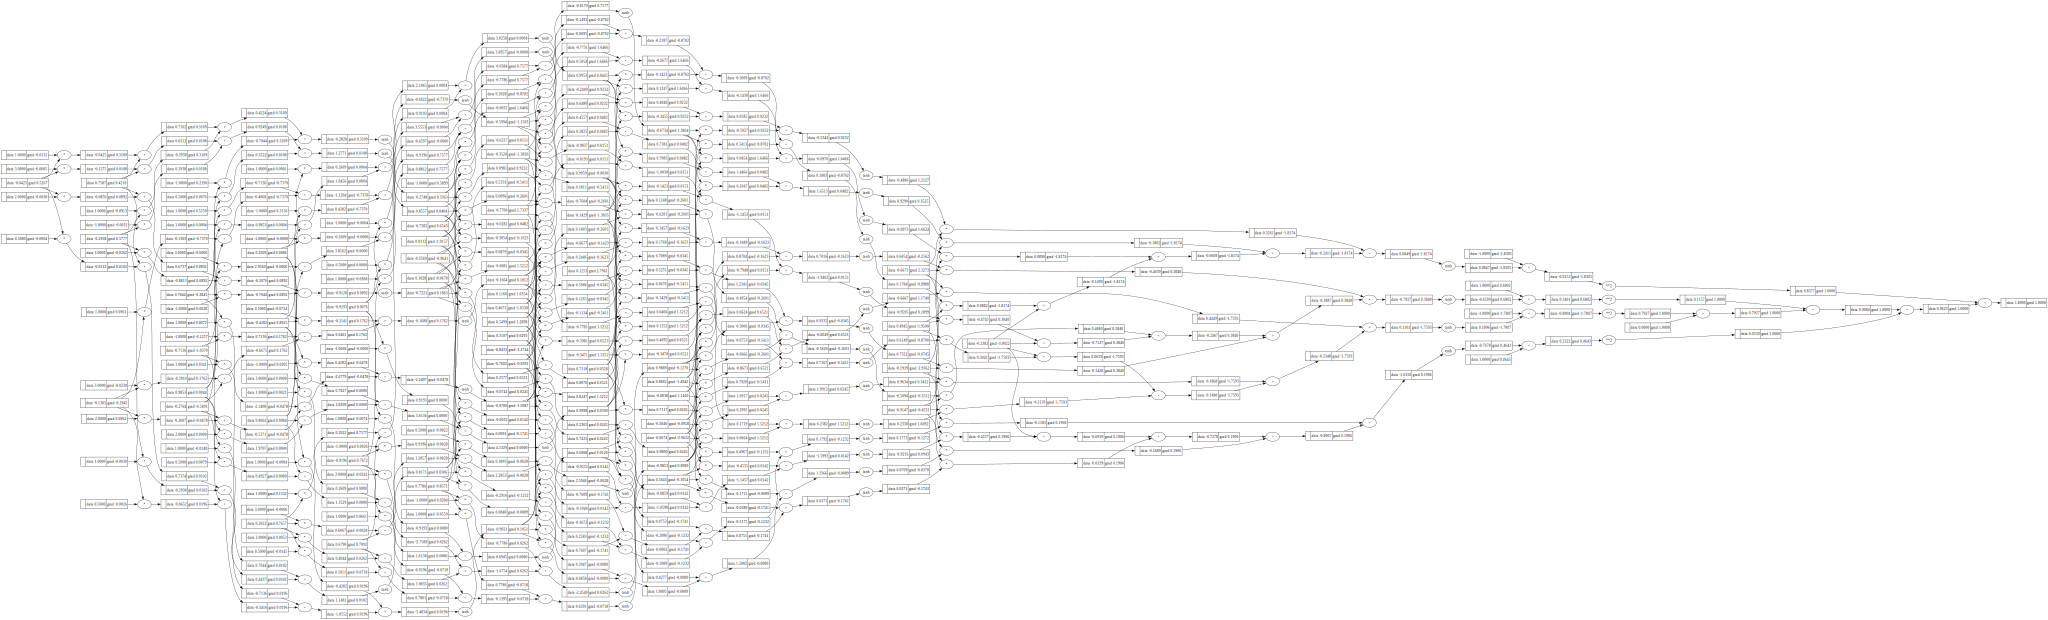

In [9]:
draw_dot(loss)